# Introduction
Finally, we achieved our goal. We classified the candidate players' plays of 2020 season, by using the Logistic Regression Model on the pca features and then ranked them according to their % of plays which belong to the valuable `cluster_3`.



After the Clustering Process took place, we are going to train several classifiers, in order to predict the testing dataset's clusters. Then, we will be able to evaluate the candidate players fo the Shooting Guard position.

**Scope**: Classify the 'plays' of the testing dataset and assign them to the respective cluster. Validate the predicted clusters and then check each candidate player's ratio of `cluster_3` plays to total plays.

In this section, we tried **Logistic Regression**, **Random Forest** and **XGBoost** classifying algorithms in order to effectively register each plays in the respective cluster. Indeed, we resulted in valid clusters, while also correctly predicted that Jrue Holiday is the winner!

In [1]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from sklearn.inspection import permutation_importance
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn import model_selection
from pickle import dump
from pickle import load
pd.set_option('display.max_columns', None)
%load_ext blackcellmagic
%config InlineBackend.figure_format = 'retina'

# 1. Useful Functions


In [3]:
def run_model(df, folds, feats, model):
    """
    Takes in a dataframe of 'plays', the # folds,
    features list and model, prints and returns
    the mean score across all the folds
    Parameters
    ---------
    df : a dataframe object
            Contains the plays
    folds : int
            Number of foldsZ
    feats : a list object
            Contains the features' columns
    model : a string object
            The model name

    Returns
    -------
    np.mean(scores) : float
            Contains the average score
    """
    
    scores = []
    for fold in range(folds):

        # get training data using folds
        df_train = df[df.kfold != fold].reset_index(drop=True)

        # get validation data using folds
        df_valid = df[df.kfold == fold].reset_index(drop=True)

        # get training data
        x_train = df_train[feats].values

        # get validation data
        x_valid = df_valid[feats].values

        # initialize Logistic Regression model
        model =  model

        # fit model on training data (ohe)
        model.fit(x_train, df_train.gm_cluster.values)

        # predict on validation data
        valid_preds = model.predict(x_valid)

        # get f1_weighted score
        f1 = f1_score(df_valid.gm_cluster.values, valid_preds, average='weighted')

        # print f1
        print(f"Fold = {fold}, F1 = {f1}")

        # register the score in the score list
        scores.append(f1)

    # print total score
    print(f"Model {model} \n===================\nMean F1 Score = {np.mean(scores)}")
    return np.mean(scores)


In [4]:
def feat_importance_mdi(df, feats, model):
    """
    Takes in a dataframe of 'plays', the
    features list and model, plots and returns
    the importances
    Parameters
    ---------
    df : a dataframe object
            Contains the plays
    feats : a list object
            Contains the features' columns
    model : a string object
            The model name
    Returns
    -------
    importances : pd.Series object
            Contains the feature importances
    """
    # define the dataset features and target
    X = df[feats]
    y = df["gm_cluster"]

    # initialize Random Forest model
    model = model

    model.fit(X, y)

    importances = model.feature_importances_

    std = np.std([
        tree.feature_importances_ for tree in model.estimators_], axis=0)

    forest_importances = pd.Series(importances, index=feats)

    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    return importances

In [5]:
def feat_importance_logres(df, feats, model):
    """
    Takes in a dataframe of 'plays', the
    features list and model, plots and returns
    the importances
    Parameters
    ---------
    df : a dataframe object
            Contains the plays
    feats : a list object
            Contains the features' columns
    model : a string object
            The model name
    Returns
    -------
    importances : pd.Series object
            Contains the feature importances
    """
    # define the dataset features and target
    X = df[feats]
    y = df["gm_cluster"]

    # initialize Random Forest model
    model = model

    model.fit(X, y)

    #importances = model.feature_importances_
    importances = model.coef_[0]
    idxs = np.argsort(importances)
    logres_importances = pd.Series(importances, index=feats)

    # summarize feature importance
    for i, v in enumerate(importances):
        print('Feature: %0d, Score: %.5f' % (i, v))

    # plot feature importance
    plt.figure(figsize=(10, 8))
    plt.title('Feature Importances')
    plt.barh(range(len(idxs)), importances[idxs], align='center')
    plt.yticks(range(len(idxs)), [feats[i] for i in idxs])
    plt.xlabel('Random Forest Feature Importance')
    plt.show()
    
    return importances

In [6]:
def feat_permutation_importance(df, feats, model):
    """
    Takes in a dataframe of 'plays', features list
    and model, plots and returns the mean score across
    all the folds
    Parameters
    ---------
    df : a dataframe object
            Contains the plays
    feats : a list object
            Contains the features' columns
    model : a string object
            The model name

    Returns
    -------
    importances : pd.Series object
            Contains the importances of features
    """
    
    # define the dataset features and target
    X = df[feats]
    y = df["gm_cluster"]

    # initialize Random Forest model
    model = model

    model.fit(X, y)

    # perform permutation importance
    results = permutation_importance(model, X, y, scoring='f1_weighted')

    # get importance
    importance = results.importances_mean
    idxs = np.argsort(importance)
    importances = pd.Series(importance, index=feats)

    # plot feature importance
    plt.title('Permutation Feature Importance', fontsize=12)
    plt.barh(range(len(idxs)), importances[idxs], align='center')
    plt.yticks(range(len(idxs)), [feats[i] for i in idxs])
    plt.xlabel('Feature Importance')
    plt.show()

    return importances

In [7]:
def compare_lists(l1, l2):
    return [j for i, j in zip(l1, l2) if i == True]

In [23]:
def rfe_process(df, feats, num_feats, model, scores):
    """
    Takes in a dataframe of 'plays', features list,
    the # features, the model and scores, prints the
    features and scores and returns score
    Parameters
    ---------
    df : a dataframe object
            Contains the plays
    feats : a list object
            Contains the features' columns
    num_feats : int
            Contains the # features
    model : a string object
            The model name
    scores  : a dictionary object
            Contains the key:value # features:scores
    Returns
    -------
    importances : pd.Series object
            Contains the importances of features
    """
    # define the dataset features and target
    X = df[feats]
    y = df["gm_cluster"]

    rfe = RFE(
        estimator=model,
        n_features_to_select=num_feats
    )

    # fit RFE
    rfe.fit(X, y)

    new_feats =  compare_lists(rfe.support_, feats)

    mean_score = run_model(df, 5, new_feats, model)

    # print total score
    print(f"Features {new_feats} \n===================\n")

    scores[num_feats] = mean_score
    return scores

# 2. Read in Data

In [9]:
# read in the data
train_df = pd.read_csv('../notebooks/plays_17_18_19_labeled_train_folds.csv',
                       converters={'GAME_ID': lambda x: str(x)})
train_df.head()

,GAME_ID,GAME_DATE,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,MIN,OFF_RATING,DEF_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,PACE,PACE_PER40,POSS,PIE,gm_cluster,pca_1,pca_2,pca_3,pca_4,NET_SCORE,kfold
0,0021800228,2018-11-17,1610612740,NOP,New Orleans,203546,Ian Clark,Ian,0,1342,133.3,98.0,0.238,1.67,38.5,0.000,0.125,0.067,23.1,0.300,0.300,0.151,104.08,86.74,48,0.028,0,-0.271162,-0.042264,0.303242,0.025082,526.4547,0
1,0021700477,2017-12-22,1610612737,ATL,Atlanta,1627819,Isaiah Taylor,Isaiah,0,1020,116.2,121.6,0.308,0.00,23.5,0.059,0.182,0.107,0.0,0.250,0.272,0.302,104.47,87.06,37,0.048,0,-0.338826,-0.101090,0.186868,0.057673,392.0488,0
2,0021801159,2019-04-01,1610612762,UTA,Utah,204060,Joe Ingles,Joe,2,1908,98.5,117.6,0.222,4.00,30.8,0.000,0.147,0.075,7.7,0.938,0.938,0.122,102.64,85.53,68,0.151,1,0.537256,0.288101,0.056215,0.166354,674.2567,0
3,0021700501,2017-12-26,1610612741,CHI,Chicago,1628374,Lauri Markkanen,Lauri,2,1193,102.2,108.9,0.056,0.00,11.1,0.077,0.278,0.159,0.0,0.214,0.190,0.151,109.84,91.53,46,0.024,1,0.233174,-0.420118,-0.127710,0.058142,443.3296,0
4,0021700677,2018-01-20,1610612763,MEM,Memphis,201936,Tyreke Evans,Tyreke,1,2129,105.7,111.6,0.286,2.00,22.2,0.000,0.121,0.056,11.1,0.250,0.338,0.266,94.03,78.36,70,0.032,3,0.154110,-0.116902,0.314140,-0.141661,741.3021,0


In [10]:
# define features
train_feats = [
    col
    for col in train_df.columns
    if col
    not in (
        "GAME_ID",
        "TEAM_ID",
        "TEAM_ABBREVIATION",
        "TEAM_CITY",
        "PLAYER_ID",
        "PLAYER_NAME",
        "NICKNAME",
        'gm_cluster',
        'pca_1',
        'pca_2',
        'pca_3',
        'pca_4',
        'NET_SCORE',
        'kfold',
        'GAME_DATE'
    )
]
train_feats


['START_POSITION',
 'MIN',
 'OFF_RATING',
 'DEF_RATING',
 'AST_PCT',
 'AST_TOV',
 'AST_RATIO',
 'OREB_PCT',
 'DREB_PCT',
 'REB_PCT',
 'TM_TOV_PCT',
 'EFG_PCT',
 'TS_PCT',
 'USG_PCT',
 'PACE',
 'PACE_PER40',
 'POSS',
 'PIE']

In [11]:
# drop redundant columns - be careful pca components belongs to
# the previous clustering process
train_df.drop(columns=['pca_1', 'pca_2', 'pca_3', 'pca_4'], inplace=True)

# 3. Normalisation

In [12]:
train_df[train_feats].shape

(62893, 18)

In [13]:
# define training data to be normalized
train_data = train_df[train_feats].values

In [14]:
# initialize scaler
scaler = MinMaxScaler()

# fit scaler
scaler.fit(train_data)

# transform data
train_data_stnd = scaler.transform(train_data)

In [15]:
train_norm_feats = [feat+'_n' for feat in train_feats]

In [16]:
train_norm_df = pd.concat([train_df.reset_index(drop=True), pd.DataFrame(
    data=train_data_stnd, columns=train_norm_feats)], axis=1)
train_norm_df.head()

,GAME_ID,GAME_DATE,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,MIN,OFF_RATING,DEF_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,PACE,PACE_PER40,POSS,PIE,gm_cluster,NET_SCORE,kfold,START_POSITION_n,MIN_n,OFF_RATING_n,DEF_RATING_n,AST_PCT_n,AST_TOV_n,AST_RATIO_n,OREB_PCT_n,DREB_PCT_n,REB_PCT_n,TM_TOV_PCT_n,EFG_PCT_n,TS_PCT_n,USG_PCT_n,PACE_n,PACE_PER40_n,POSS_n,PIE_n
0,0021800228,2018-11-17,1610612740,NOP,New Orleans,203546,Ian Clark,Ian,0,1342,133.3,98.0,0.238,1.67,38.5,0.000,0.125,0.067,23.1,0.300,0.300,0.151,104.08,86.74,48,0.028,0,526.4547,0,0.000000,0.400597,0.380857,0.24500,0.238,0.098235,0.385,0.000,0.125,0.067,0.231,0.200000,0.200000,0.151,0.007225,0.007225,0.396694,0.430571
1,0021700477,2017-12-22,1610612737,ATL,Atlanta,1627819,Isaiah Taylor,Isaiah,0,1020,116.2,121.6,0.308,0.00,23.5,0.059,0.182,0.107,0.0,0.250,0.272,0.302,104.47,87.06,37,0.048,0,392.0488,0,0.000000,0.304478,0.332000,0.30400,0.308,0.000000,0.235,0.059,0.182,0.107,0.000,0.166667,0.181333,0.302,0.007252,0.007252,0.305785,0.432000
2,0021801159,2019-04-01,1610612762,UTA,Utah,204060,Joe Ingles,Joe,2,1908,98.5,117.6,0.222,4.00,30.8,0.000,0.147,0.075,7.7,0.938,0.938,0.122,102.64,85.53,68,0.151,1,674.2567,0,0.666667,0.569552,0.281429,0.29400,0.222,0.235294,0.308,0.000,0.147,0.075,0.077,0.625333,0.625333,0.122,0.007125,0.007125,0.561983,0.439357
3,0021700501,2017-12-26,1610612741,CHI,Chicago,1628374,Lauri Markkanen,Lauri,2,1193,102.2,108.9,0.056,0.00,11.1,0.077,0.278,0.159,0.0,0.214,0.190,0.151,109.84,91.53,46,0.024,1,443.3296,0,0.666667,0.356119,0.292000,0.27225,0.056,0.000000,0.111,0.077,0.278,0.159,0.000,0.142667,0.126667,0.151,0.007625,0.007624,0.380165,0.430286
4,0021700677,2018-01-20,1610612763,MEM,Memphis,201936,Tyreke Evans,Tyreke,1,2129,105.7,111.6,0.286,2.00,22.2,0.000,0.121,0.056,11.1,0.250,0.338,0.266,94.03,78.36,70,0.032,3,741.3021,0,0.333333,0.635522,0.302000,0.27900,0.286,0.117647,0.222,0.000,0.121,0.056,0.111,0.166667,0.225333,0.266,0.006527,0.006527,0.578512,0.430857


# 4. Try a Baseline Model

In [17]:
# initialize Logistic Regression model
logres = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    n_jobs=-1)

In [18]:
run_model(train_norm_df, 5, train_norm_feats, logres)

Fold = 0, F1 = 0.9954893044231355
Fold = 1, F1 = 0.9959608535672826
Fold = 2, F1 = 0.9964345770452878
Fold = 3, F1 = 0.9964386813805151
Fold = 4, F1 = 0.9956466870928642
Model LogisticRegression(multi_class='multinomial', n_jobs=-1) 
Mean F1 Score = 0.9959940207018171


0.9959940207018171

We shouldn't be comfortable with such a tremendous accuracy from the very beggining. Let's check the features importance. You may call the `feat_immportance_mdi` or `feat_importance_logres` functions to do that. Yet, I choose the `feat_permutation_importance` to be able to use those conclusions to all the models - permutation importance is model agnostic.

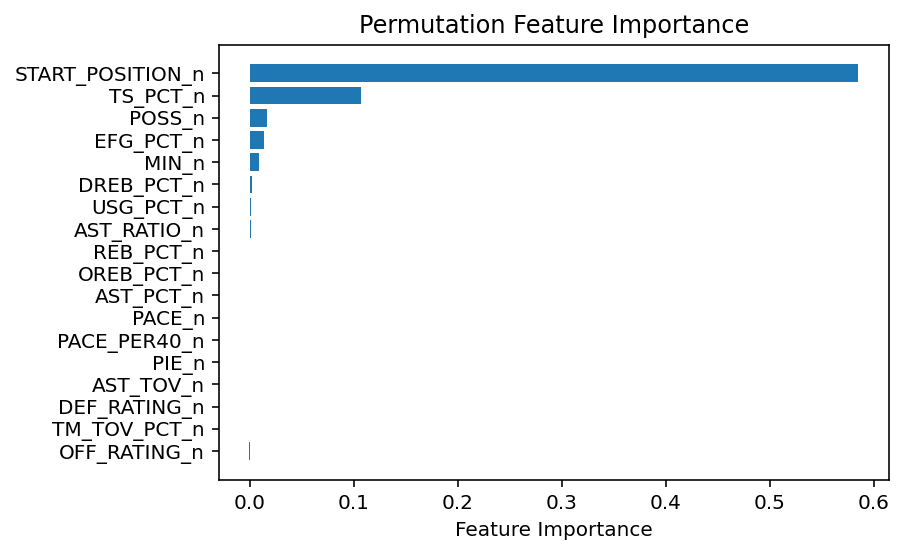

START_POSITION_n    5.848599e-01
MIN_n               9.491736e-03
OFF_RATING_n       -1.129661e-04
DEF_RATING_n       -1.891144e-05
AST_PCT_n           3.611772e-06
AST_TOV_n          -8.755373e-06
AST_RATIO_n         9.523316e-04
OREB_PCT_n          1.052978e-04
DREB_PCT_n          2.378054e-03
REB_PCT_n           4.930658e-04
TM_TOV_PCT_n       -5.372052e-05
EFG_PCT_n           1.417209e-02
TS_PCT_n            1.070081e-01
USG_PCT_n           1.171790e-03
PACE_n              0.000000e+00
PACE_PER40_n        0.000000e+00
POSS_n              1.637553e-02
PIE_n              -2.080848e-10
dtype: float64

In [19]:
feat_permutation_importance(train_norm_df, train_norm_feats, logres)

It is very suspicious for a feature to contribute so high importance, hence it has to be further examined.

In [20]:
run_model(train_norm_df, 5, ['START_POSITION_n'], logres)

Fold = 0, F1 = 0.8657678611548529
Fold = 1, F1 = 0.86574740253879
Fold = 2, F1 = 0.8660200754897905
Fold = 3, F1 = 0.8667443048794484
Fold = 4, F1 = 0.8656126928897967
Model LogisticRegression(multi_class='multinomial', n_jobs=-1) 
Mean F1 Score = 0.8659784673905356


0.8659784673905356

Even by using `START_POSITION_n` itself exlusively, we achieve a F1 score of 0.87! We shouldn't be happy, as this is an indicator that the feature potentially fosters overfitting! Let's check the mean stats for the group_1 feats across all the `START_POSITION` values:

In [21]:
group_1 = ['OFF_RATING', 'AST_PCT', 'AST_TOV', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'POSS']

In [22]:
train_norm_df.groupby(by='START_POSITION').agg(np.mean)[group_1]

,OFF_RATING,AST_PCT,AST_TOV,TM_TOV_PCT,EFG_PCT,TS_PCT,POSS
START_POSITION,,,,,,,
0,101.680642,0.120858,0.655623,10.245366,0.455788,0.486946,34.830412
1,108.583286,0.217609,2.013673,10.038103,0.504163,0.539964,64.867027
2,108.151839,0.119372,1.155329,9.782779,0.520350,0.552918,62.546659
3,108.147874,0.114246,0.995818,11.557729,0.562291,0.589391,56.833615


In [23]:
# remember the encoding
""" mapping = {
    "NaN": 0,
    "G": 1,
    "F": 2, 
    "C": 3
    } """

' mapping = {\n    "NaN": 0,\n    "G": 1,\n    "F": 2, \n    "C": 3\n    } '

And that is; `OFF_RATING`, `AST_TOV`, `EFG_PCT`, `TS_PCT` & `POSS` get the minimum levels for the `START_POSITION` 0 or else NaN. Which means that this variable *betrays* that those players didn't start the game, hence there is high possibility for them to have played less time than the other and as a result have worse stats. To be more particular, the less you play the lower the chance to increase any records (pass, points, etc). In the same context, another variable may also be guilty; `MIN`. It precisely expresses the time a player spent in the court and so we have to ignore it, too.

In [24]:
# re-define norm_feats
train_norm_feats.remove('START_POSITION_n')

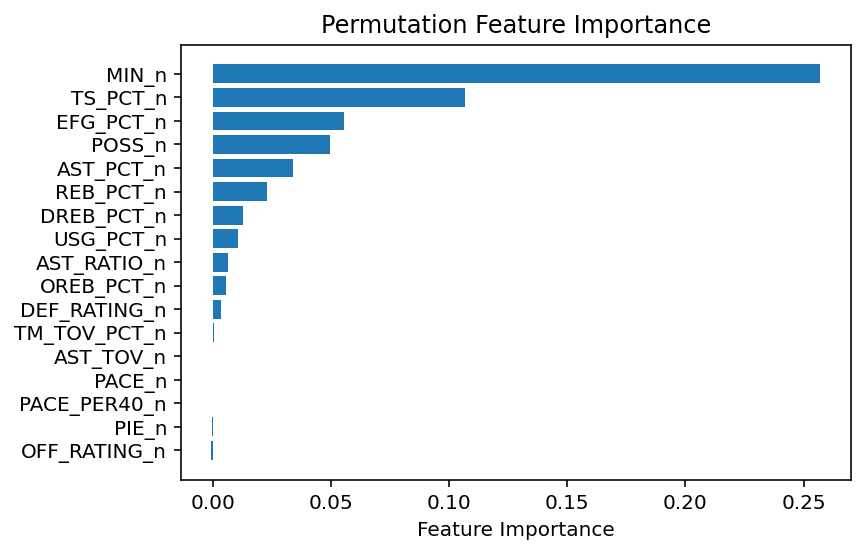

MIN_n           0.257013
OFF_RATING_n   -0.000494
DEF_RATING_n    0.003666
AST_PCT_n       0.033799
AST_TOV_n      -0.000010
AST_RATIO_n     0.006476
OREB_PCT_n      0.005636
DREB_PCT_n      0.012753
REB_PCT_n       0.023108
TM_TOV_PCT_n    0.000613
EFG_PCT_n       0.055581
TS_PCT_n        0.106817
USG_PCT_n       0.010797
PACE_n         -0.000028
PACE_PER40_n   -0.000028
POSS_n          0.049829
PIE_n          -0.000170
dtype: float64

In [25]:
feat_permutation_importance(train_norm_df, train_norm_feats, logres)

Indeed, the same applies for the case of `MIN` - it leaks information of the time spent in the court by the athlete. So, the model knows 'apriori' that the player with higher duration may have better stats.

Now we have to repeat the normalization in order for the scaler to be fit in the new shape of data [: , 16] instead of [: , 18].

In [26]:
# re-define norm_feats
train_norm_feats.remove('MIN_n')

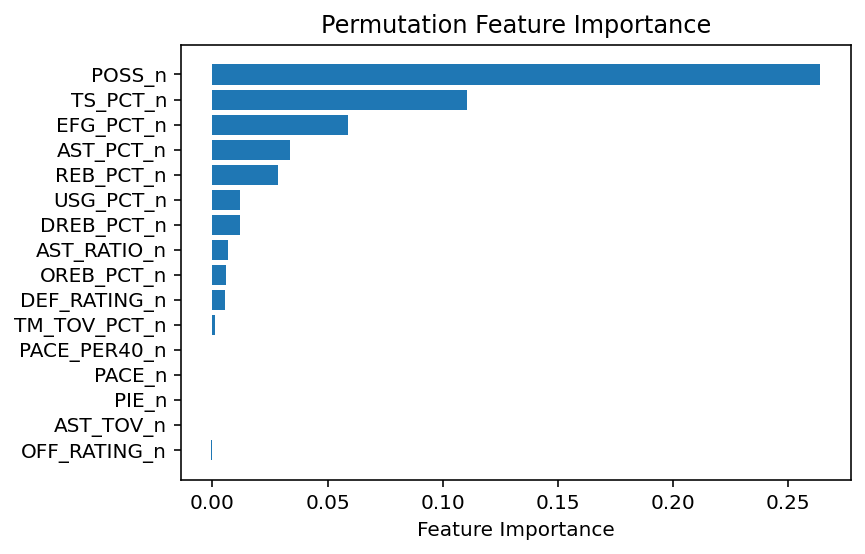

OFF_RATING_n   -0.000403
DEF_RATING_n    0.005359
AST_PCT_n       0.033888
AST_TOV_n      -0.000196
AST_RATIO_n     0.006674
OREB_PCT_n      0.005726
DREB_PCT_n      0.011846
REB_PCT_n       0.028436
TM_TOV_PCT_n    0.001163
EFG_PCT_n       0.058973
TS_PCT_n        0.110379
USG_PCT_n       0.011905
PACE_n         -0.000015
PACE_PER40_n   -0.000015
POSS_n          0.263922
PIE_n          -0.000161
dtype: float64

In [27]:
feat_permutation_importance(train_norm_df, train_norm_feats, logres)

In [28]:
# re-define feats
train_feats.remove('START_POSITION')
train_feats.remove('MIN')

In [29]:
train_df[train_feats].shape

(62893, 16)

In [30]:
# define training data to be normalized
train_data = train_df[train_feats].values

In [31]:
# initialize scaler
scaler = MinMaxScaler()

# fit scaler
scaler.fit(train_data)

# transform data
train_data_stnd = scaler.transform(train_data)

In [32]:
# save the scaler
dump(scaler, open('scaler.pkl', 'wb'))

In [33]:
train_norm_feats = [feat+'_n' for feat in train_feats]

In [34]:
# complete training dataset
train_norm_df = pd.concat([train_df.reset_index(drop=True), pd.DataFrame(
    data=train_data_stnd, columns=train_norm_feats)], axis=1)
train_norm_df.head()

,GAME_ID,GAME_DATE,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,MIN,OFF_RATING,DEF_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,PACE,PACE_PER40,POSS,PIE,gm_cluster,NET_SCORE,kfold,OFF_RATING_n,DEF_RATING_n,AST_PCT_n,AST_TOV_n,AST_RATIO_n,OREB_PCT_n,DREB_PCT_n,REB_PCT_n,TM_TOV_PCT_n,EFG_PCT_n,TS_PCT_n,USG_PCT_n,PACE_n,PACE_PER40_n,POSS_n,PIE_n
0,0021800228,2018-11-17,1610612740,NOP,New Orleans,203546,Ian Clark,Ian,0,1342,133.3,98.0,0.238,1.67,38.5,0.000,0.125,0.067,23.1,0.300,0.300,0.151,104.08,86.74,48,0.028,0,526.4547,0,0.380857,0.24500,0.238,0.098235,0.385,0.000,0.125,0.067,0.231,0.200000,0.200000,0.151,0.007225,0.007225,0.396694,0.430571
1,0021700477,2017-12-22,1610612737,ATL,Atlanta,1627819,Isaiah Taylor,Isaiah,0,1020,116.2,121.6,0.308,0.00,23.5,0.059,0.182,0.107,0.0,0.250,0.272,0.302,104.47,87.06,37,0.048,0,392.0488,0,0.332000,0.30400,0.308,0.000000,0.235,0.059,0.182,0.107,0.000,0.166667,0.181333,0.302,0.007252,0.007252,0.305785,0.432000
2,0021801159,2019-04-01,1610612762,UTA,Utah,204060,Joe Ingles,Joe,2,1908,98.5,117.6,0.222,4.00,30.8,0.000,0.147,0.075,7.7,0.938,0.938,0.122,102.64,85.53,68,0.151,1,674.2567,0,0.281429,0.29400,0.222,0.235294,0.308,0.000,0.147,0.075,0.077,0.625333,0.625333,0.122,0.007125,0.007125,0.561983,0.439357
3,0021700501,2017-12-26,1610612741,CHI,Chicago,1628374,Lauri Markkanen,Lauri,2,1193,102.2,108.9,0.056,0.00,11.1,0.077,0.278,0.159,0.0,0.214,0.190,0.151,109.84,91.53,46,0.024,1,443.3296,0,0.292000,0.27225,0.056,0.000000,0.111,0.077,0.278,0.159,0.000,0.142667,0.126667,0.151,0.007625,0.007624,0.380165,0.430286
4,0021700677,2018-01-20,1610612763,MEM,Memphis,201936,Tyreke Evans,Tyreke,1,2129,105.7,111.6,0.286,2.00,22.2,0.000,0.121,0.056,11.1,0.250,0.338,0.266,94.03,78.36,70,0.032,3,741.3021,0,0.302000,0.27900,0.286,0.117647,0.222,0.000,0.121,0.056,0.111,0.166667,0.225333,0.266,0.006527,0.006527,0.578512,0.430857


# 4. PCA

In [35]:
train_data_pca = train_norm_df.loc[:, train_norm_feats].values

In [36]:
# PCA
pca = PCA()
pca.fit(train_data_pca)
pca.explained_variance_ratio_

array([3.53053580e-01, 2.13948051e-01, 1.29760113e-01, 8.45612895e-02,
       7.29745272e-02, 4.55120008e-02, 2.51668401e-02, 2.07013473e-02,
       1.65468338e-02, 1.62982039e-02, 1.08856906e-02, 8.46174323e-03,
       1.11444307e-03, 5.17433514e-04, 4.97902950e-04, 2.42506943e-13])

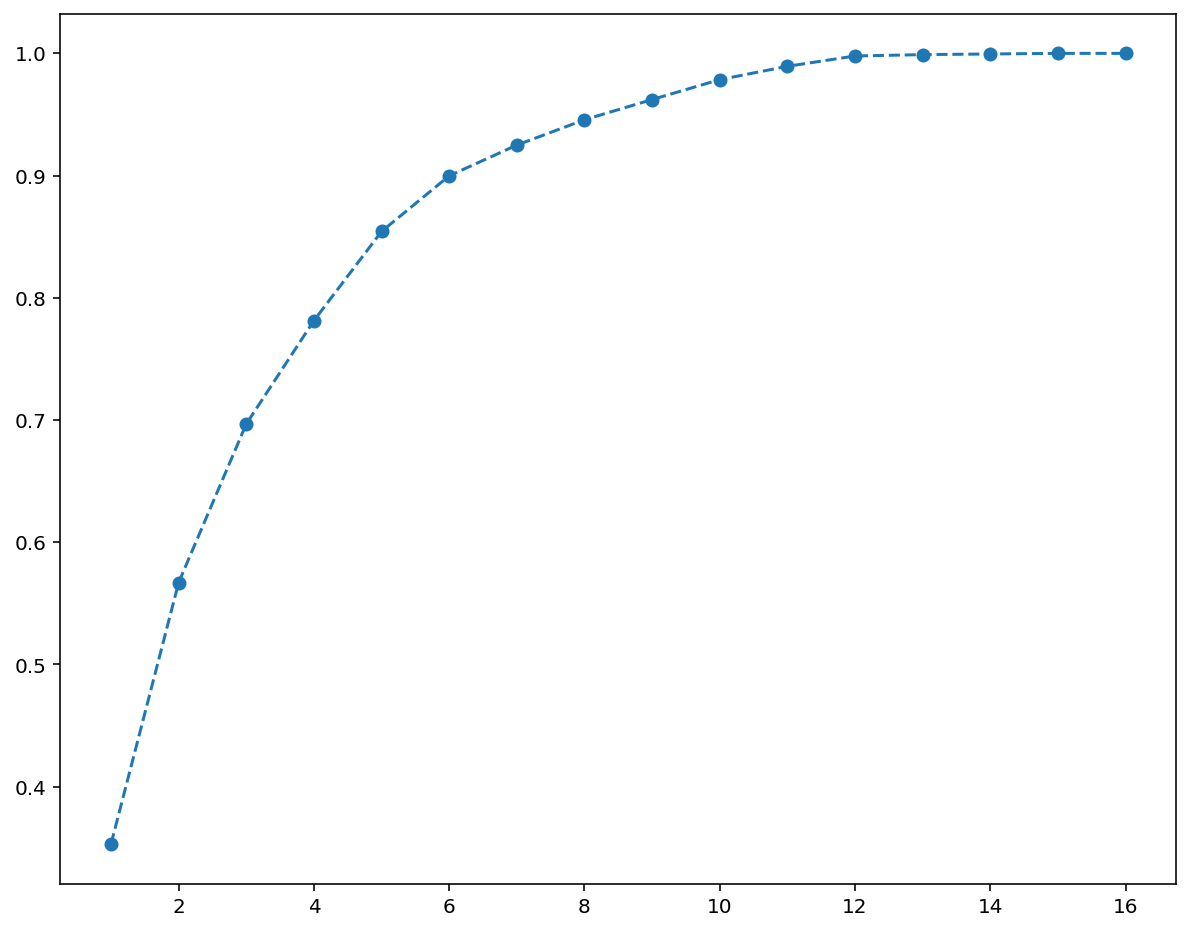

In [37]:
plt.figure(figsize=(10, 8))
plt.plot(range(1, 17), pca.explained_variance_ratio_.cumsum(),
         marker='o', linestyle='--')

We may choose any number of components which is above 7, as it explains at least 90% of the data variance.

In [38]:
# choose 9, retaining almost all the variance level
pca = PCA(n_components=9)
pca.fit(train_data_pca)
train_pca_scores = pca.transform(train_data_pca)

In [39]:
train_norm_pca_df = pd.concat([train_norm_df.reset_index(drop=True), pd.DataFrame(
    data=train_pca_scores, columns=['pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8', 'pca_9'])], axis=1)

In [40]:
train_pca_feats = ["pca_"+f"{i}" for i in range(1, 10)]

In [41]:
# save the pca object
dump(pca, open('pca.pkl', 'wb'))

In [42]:
train_norm_pca_df.head()

,GAME_ID,GAME_DATE,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,MIN,OFF_RATING,DEF_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,PACE,PACE_PER40,POSS,PIE,gm_cluster,NET_SCORE,kfold,OFF_RATING_n,DEF_RATING_n,AST_PCT_n,AST_TOV_n,AST_RATIO_n,OREB_PCT_n,DREB_PCT_n,REB_PCT_n,TM_TOV_PCT_n,EFG_PCT_n,TS_PCT_n,USG_PCT_n,PACE_n,PACE_PER40_n,POSS_n,PIE_n,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9
0,0021800228,2018-11-17,1610612740,NOP,New Orleans,203546,Ian Clark,Ian,0,1342,133.3,98.0,0.238,1.67,38.5,0.000,0.125,0.067,23.1,0.300,0.300,0.151,104.08,86.74,48,0.028,0,526.4547,0,0.380857,0.24500,0.238,0.098235,0.385,0.000,0.125,0.067,0.231,0.200000,0.200000,0.151,0.007225,0.007225,0.396694,0.430571,-0.156928,0.250151,0.044624,0.056692,0.105830,-0.104343,-0.007510,0.042418,-0.082759
1,0021700477,2017-12-22,1610612737,ATL,Atlanta,1627819,Isaiah Taylor,Isaiah,0,1020,116.2,121.6,0.308,0.00,23.5,0.059,0.182,0.107,0.0,0.250,0.272,0.302,104.47,87.06,37,0.048,0,392.0488,0,0.332000,0.30400,0.308,0.000000,0.235,0.059,0.182,0.107,0.000,0.166667,0.181333,0.302,0.007252,0.007252,0.305785,0.432000,-0.212663,0.157254,0.066799,0.036626,-0.099013,0.153766,-0.109900,0.044364,-0.049816
2,0021801159,2019-04-01,1610612762,UTA,Utah,204060,Joe Ingles,Joe,2,1908,98.5,117.6,0.222,4.00,30.8,0.000,0.147,0.075,7.7,0.938,0.938,0.122,102.64,85.53,68,0.151,1,674.2567,0,0.281429,0.29400,0.222,0.235294,0.308,0.000,0.147,0.075,0.077,0.625333,0.625333,0.122,0.007125,0.007125,0.561983,0.439357,0.452645,0.160270,0.039474,-0.033602,0.006235,-0.071279,0.117892,-0.082276,0.040672
3,0021700501,2017-12-26,1610612741,CHI,Chicago,1628374,Lauri Markkanen,Lauri,2,1193,102.2,108.9,0.056,0.00,11.1,0.077,0.278,0.159,0.0,0.214,0.190,0.151,109.84,91.53,46,0.024,1,443.3296,0,0.292000,0.27225,0.056,0.000000,0.111,0.077,0.278,0.159,0.000,0.142667,0.126667,0.151,0.007625,0.007624,0.380165,0.430286,-0.274834,-0.043529,-0.090116,0.076022,-0.196391,-0.028634,-0.021253,0.007010,0.001708
4,0021700677,2018-01-20,1610612763,MEM,Memphis,201936,Tyreke Evans,Tyreke,1,2129,105.7,111.6,0.286,2.00,22.2,0.000,0.121,0.056,11.1,0.250,0.338,0.266,94.03,78.36,70,0.032,3,741.3021,0,0.302000,0.27900,0.286,0.117647,0.222,0.000,0.121,0.056,0.111,0.166667,0.225333,0.266,0.006527,0.006527,0.578512,0.430857,-0.105111,0.248742,-0.172220,-0.004472,0.035516,0.071972,-0.030637,-0.016687,-0.032552


In [43]:
train_norm_pca_df.describe()

,TEAM_ID,PLAYER_ID,START_POSITION,MIN,OFF_RATING,DEF_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,PACE,PACE_PER40,POSS,PIE,gm_cluster,NET_SCORE,kfold,OFF_RATING_n,DEF_RATING_n,AST_PCT_n,AST_TOV_n,AST_RATIO_n,OREB_PCT_n,DREB_PCT_n,REB_PCT_n,TM_TOV_PCT_n,EFG_PCT_n,TS_PCT_n,USG_PCT_n,PACE_n,PACE_PER40_n,POSS_n,PIE_n,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9
count,6.289300e+04,6.289300e+04,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,6.289300e+04,6.289300e+04,6.289300e+04,6.289300e+04,6.289300e+04,6.289300e+04,6.289300e+04,6.289300e+04,6.289300e+04
mean,1.610613e+09,7.738542e+05,0.848012,1365.656671,104.810268,107.299081,0.138187,1.037766,16.197189,0.040010,0.136368,0.088292,10.242790,0.487106,0.519022,0.184114,103.341069,86.117551,47.786987,0.088271,1.028000,502.890269,1.999952,0.299458,0.268248,0.138187,0.061045,0.161972,0.040010,0.136368,0.088292,0.102428,0.324737,0.346015,0.184114,0.007174,0.007174,0.394934,0.434876,-9.602998e-19,6.326681e-18,-4.017725e-17,-3.869443e-18,-1.293580e-17,-2.909143e-18,-5.648822e-18,-4.126465e-17,3.813661e-17
std,8.687631e+00,7.121047e+05,1.034959,613.196751,23.251576,23.058018,0.140800,1.579515,15.515182,0.060202,0.110823,0.069152,12.341289,0.281903,0.270811,0.083798,104.927575,87.439643,21.401744,0.163042,1.129725,200.314523,1.414219,0.066433,0.057645,0.140800,0.092913,0.155152,0.060202,0.110823,0.069152,0.123413,0.187935,0.180541,0.083798,0.007284,0.007284,0.176874,0.011646,2.674796e-01,2.082210e-01,1.621589e-01,1.309050e-01,1.216063e-01,9.603582e-02,7.141421e-02,6.476936e-02,5.790656e-02
min,1.610613e+09,1.713000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000,0.000000,-51.868000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.427710e-01,-5.554648e-01,-4.922404e-01,-2.492859e-01,-8.029511e-01,-5.465089e-01,-3.155748e-01,-4.132603e-01,-5.091295e-01
25%,1.610613e+09,2.023340e+05,0.000000,935.000000,93.800000,95.700000,0.000000,0.000000,0.000000,0.000000,0.061000,0.042000,0.000000,0.333000,0.375000,0.130000,96.610000,80.510000,33.000000,0.036000,0.000000,365.745200,1.000000,0.268000,0.239250,0.000000,0.000000,0.000000,0.000000,0.061000,0.042000,0.000000,0.222000,0.250000,0.130000,0.006706,0.006706,0.272727,0.431143,-1.353790e-01,-1.606643e-01,-1.149714e-01,-8.763977e-02,-7.006448e-02,-5.434727e-02,-4.013659e-02,-3.671109e-02,-3.316983e-02
50%,1.610613e+09,2.038970e+05,0.000000,1416.000000,106.300000,107.100000,0.111000,0.330000,14.300000,0.000000,0.120000,0.077000,8.300000,0.500000,0.532000,0.180000,100.880000,84.060000,50.000000,0.089000,1.000000,519.509000,2.000000,0.303714,0.267750,0.111000,0.019412,0.143000,0.000000,0.120000,0.077000,0.083000,0.333333,0.354667,0.180000,0.007003,0.007002,0.413223,0.434929,3.618131e-02,-1.529126e-02,-1.115034e-02,-1.742548e-02,-7.880601e-03,-3.241807e-03,-6.228617e-03,-5.267662e-03,-2.246828e-03
75%,1.610613e+09,1.627780e+06,2.000000,1852.000000,118.200000,119.200000,0.208000,1.500000,25.000000,0.061000,0.192000,0.123000,15.400000,0.667000,0.680000,0.235000,105.520000,87.930000,65.000000,0.143000,2.000000,659.107100,3.000000,0.337714,0.298000,0.208000,0.088235,0.250000,0.061000,0.192000,0.123000,0.154000,0.444667,0.453333,0.235000,0.007325,0.007325,0.537190,0.438786,1.759612e-01,1.307583e-01,9.609096e-02,6.665680e-02,5.896816e-02,5.224710e-02,3.120275e-

# 5. Logistic Regression

In [ ]:
# initialize Logistic Regression model this time to further explore its potential
logres = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    n_jobs=-1)

In [ ]:
feat_permutation_importance(train_norm_pca_df, train_norm_feats, logres)

For the `POSS` we shouldn't think the same as in the case of `MIN`, though. That is because, having the ball for much time in his possesion, doesn't necessarily mean the player played more. There can be situations where one player contribute less by holding possesion and more by moving around the court to 'open' spaces for his teammates.

In [44]:
# drop completely insignificant feats
drop_norm_feats = ['OFF_RATING_n', 'AST_TOV_n', 'PACE_n', 'PACE_PER40_n', 'PIE_n']
drop_feats = ['OFF_RATING', 'AST_TOV', 'PACE', 'PACE_PER40', 'PIE']

In [45]:
# introduce the updated list of significant feats
train_sgnft_norm_feats = [feat for feat in train_norm_feats if feat not in drop_norm_feats]
train_sgnft_feats = [feat for feat in train_feats if feat not in drop_feats]

In [ ]:
# run again for the updated feats list
run_model(train_norm_pca_df, 5, train_norm_feats, logres)

In [ ]:
run_model(train_norm_pca_df, 5, train_sgnft_feats, logres)

GridSearch

In [ ]:
# define a grid of parameters
param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100]
}

In [ ]:
# initialize grid search
# estimator is the model that we have defined
# we use f1_weighted as our metric
# cv=5 means that we are using 5 fold cv
model = model_selection.GridSearchCV(
    estimator=logres,
    param_grid=param_grid,
    scoring="f1_weighted",
    verbose=10,
    n_jobs=1,
    cv=5
)

In [ ]:
X = train_norm_pca_df[train_sgnft_norm_feats].values
y = train_norm_pca_df.gm_cluster.values

In [ ]:
# fit model on training data
model.fit(X, y)

print(f"Best score: {model.best_score_}")

print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print(f"\t{param_name}: {best_parameters[param_name]}")

Run Optimised Model

In [46]:
# initialize tuned Logistic Regression model
tuned_logres = LogisticRegression(
    multi_class='multinomial',
    C=10,
    solver='lbfgs',
    n_jobs=-1)

In [47]:
run_model(train_norm_pca_df, 5, train_sgnft_norm_feats, tuned_logres)

Fold = 0, F1 = 0.7210065254455786
Fold = 1, F1 = 0.7126623371558759
Fold = 2, F1 = 0.7127461271623243
Fold = 3, F1 = 0.7129990714916258
Fold = 4, F1 = 0.7170854918384136
Model LogisticRegression(C=10, multi_class='multinomial', n_jobs=-1) 
Mean F1 Score = 0.7152999106187636


0.7152999106187636

In [48]:
run_model(train_norm_pca_df, 5, train_norm_feats, tuned_logres)

Fold = 0, F1 = 0.7199177830591433
Fold = 1, F1 = 0.7121452038415015
Fold = 2, F1 = 0.7139589562048474
Fold = 3, F1 = 0.7107972206722304
Fold = 4, F1 = 0.7153891160119202
Model LogisticRegression(C=10, multi_class='multinomial', n_jobs=-1) 
Mean F1 Score = 0.7144416559579285


0.7144416559579285

In [49]:
run_model(train_norm_pca_df, 5, train_pca_feats, tuned_logres)

Fold = 0, F1 = 0.7153555330933105
Fold = 1, F1 = 0.7094261937120924
Fold = 2, F1 = 0.7076687543348589
Fold = 3, F1 = 0.7086330694327273
Fold = 4, F1 = 0.7148523094846864
Model LogisticRegression(C=10, multi_class='multinomial', n_jobs=-1) 
Mean F1 Score = 0.7111871720115351


0.7111871720115351

In [ ]:
# rducd_norm_feats
""" Best score: 0.7129040085726503
Best parameters set:
	C: 100 """

# tunned + all_norm_feats
# 0.7200434027303044 | 0.7127641638161785 % 0.7142677011439387 | %% 0.7144416559579285

# tuned + sgnft_norm_feats
# 0.7129040085726503 | 0.7130101776176886 % 0.7154034911987911 | %% 0.7152999106187636

# tuned + 9_pca_feats
# 0.7097072881908655 | 0.709740666424608 % 0.7113750832534707 | %% 0.7111802053648798

# tuned + 7_pca_feats
# 0.7076065938445443 |

# 5. Random Forest

In [ ]:
# initialize Random Forest model
rf = ensemble.RandomForestClassifier(
    n_jobs=-1
    )

In [ ]:
run_model(train_norm_pca_df, 5, train_feats, rf)

In [ ]:
run_model(train_norm_pca_df, 5, train_sgnft_feats, rf)

In [ ]:
X = train_norm_pca_df[train_sgnft_feats].values
y = train_norm_pca_df.gm_cluster.values

Grid Search

In [ ]:
# define a grid of parameters
param_grid = {
    "n_estimators": [100, 200, 250, 300, 400, 500],
    "max_depth": [1, 2, 5, 7, 11, 15],
    "criterion": ["gini", "entropy"]
}

In [ ]:
# initialize grid search
# we use f1_weighted as our metric
# cv=5 means that we are using 5 fold cv
model = model_selection.GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="f1_weighted",
    verbose=10,
    n_jobs=1,
    cv=5
)

In [ ]:
# fit model on training data
model.fit(X, y)

# get best score
print(f"Best score: {model.best_score_}")

# get best params
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print(f"\t{param_name}: {best_parameters[param_name]}")

Run optimised model

In [50]:
# initialize tuned Random Forest model
tuned_rf = ensemble.RandomForestClassifier(
    criterion='gini',
    max_depth=15,
    n_estimators=500,
    n_jobs=-1
)

In [51]:
run_model(train_norm_pca_df, 5, train_sgnft_feats, tuned_rf)

Fold = 0, F1 = 0.7149265055471972
Fold = 1, F1 = 0.7129901731115438
Fold = 2, F1 = 0.7115056863897531
Fold = 3, F1 = 0.713448676792057
Fold = 4, F1 = 0.7184251194569914
Model RandomForestClassifier(max_depth=15, n_estimators=500, n_jobs=-1) 
Mean F1 Score = 0.7142592322595085


0.7142592322595085

In [52]:
run_model(train_norm_pca_df, 5, train_pca_feats, tuned_rf)

Fold = 0, F1 = 0.714892191984384
Fold = 1, F1 = 0.7056267711401844
Fold = 2, F1 = 0.7090479500528962
Fold = 3, F1 = 0.7092944571334843
Fold = 4, F1 = 0.71128187233277
Model RandomForestClassifier(max_depth=15, n_estimators=500, n_jobs=-1) 
Mean F1 Score = 0.7100286485287438


0.7100286485287438

In [53]:
run_model(train_norm_pca_df, 5, train_feats, tuned_rf)

Fold = 0, F1 = 0.7225858623953599
Fold = 1, F1 = 0.7197238650637885
Fold = 2, F1 = 0.7206339604632716
Fold = 3, F1 = 0.7206203926808615
Fold = 4, F1 = 0.7248362448977436
Model RandomForestClassifier(max_depth=15, n_estimators=500, n_jobs=-1) 
Mean F1 Score = 0.721680065100205


0.721680065100205

In [ ]:
# grid % sgnft_feats
""" Best score: 0.7156545519496949
Best parameters set:
	criterion: gini
	max_depth: 15
	n_estimators: 500 """

# tunned + all_feats
# 0.7200434027303044  |  0.7192813050485303  | % 0.7210305851291254 | %% 0.7213350940732122

# tunned + sgnft_feats
# 0.7143466533806893  |  0.7127733551992773  | % 0.7150202352402397 | %% 0.7145480249098884

# tuned + 9_pca_feats
# 0.7081434070788928  |  0.7076707318212638  | % 0.7094585180763383 | %% 0.7100286485287438

# tunned + 7_pca_feats
# 0.7049798741665684

# 6. XGBoost

In [ ]:
# initialize XGboost Classifier model
xgb_clf = xgb.XGBClassifier(
    n_jobs=-1
)

In [ ]:
run_model(train_norm_pca_df, 5, train_feats, xgb_clf)

In [ ]:
run_model(train_norm_pca_df, 5, train_sgnft_feats, xgb_clf)

GridSearch

In [ ]:
# define a grid of parameters
param_grid = {
    "max_depth": [3, 5, 7],
    "colsample_bytree": [0.5, 1.0],
    "lambda": [0.1, 1.0],
    "n_estimators": [50, 100, 200]
}

In [ ]:
# initialize grid search

# we use f1 as our metric
# cv=5 means that we are using 5 fold cv
model = model_selection.GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring="f1_weighted",
    verbose=10,
    n_jobs=1,
    cv=5
)

In [ ]:
# fit model on training data
model.fit(X, y)

# get best score
print(f"Best score: {model.best_score_}")

# get best params
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print(f"\t{param_name}: {best_parameters[param_name]}")

In [55]:
# initialize the best XGboost
tuned_xgb = xgb.XGBClassifier(
    colsample_bytree=1.0,
   	reg_lambda=0.1,
   	max_depth=3,
   	n_estimators=200,
    n_jobs=-1
)

In [56]:
run_model(train_norm_pca_df, 5, train_feats, tuned_xgb)

Fold = 0, F1 = 0.7236516579892617
Fold = 1, F1 = 0.7208955630996015
Fold = 2, F1 = 0.725326197715115
Fold = 3, F1 = 0.7232827045915096
Fold = 4, F1 = 0.7260498365320814
Model XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=0.1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None) 
Mean F1 Score = 0.7238411919855139


0.7238411919855139

In [57]:
run_model(train_norm_pca_df, 5, train_sgnft_feats, tuned_xgb)

Fold = 0, F1 = 0.7185530936207463
Fold = 1, F1 = 0.7128904594986912
Fold = 2, F1 = 0.7171222926111861
Fold = 3, F1 = 0.7174734944503384
Fold = 4, F1 = 0.7180184238854784
Model XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=0.1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None) 
Mean F1 Score = 0.7168115528132881


0.7168115528132881

In [58]:
run_model(train_norm_pca_df, 5, train_pca_feats, tuned_xgb)

Fold = 0, F1 = 0.7158557957440344
Fold = 1, F1 = 0.7051130615587947
Fold = 2, F1 = 0.7092843940901489
Fold = 3, F1 = 0.7087823311074584
Fold = 4, F1 = 0.713252385639888
Model XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=0.1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None) 
Mean F1 Score = 0.7104575936280648


0.7104575936280648

In [ ]:
""" Best score: 0.718131949373753
Best parameters set:
	colsample_bytree: 1.0
	lambda: 0.1
	max_depth: 3
	n_estimators: 200 """
	

# tunned + all_feats
# 0.7237187801347641  |  0.723295078704803  | %0.7238411919855139 | %% 0.7238411919855139


# tunned + sgnft_feats
# 0.7179928505381048  |  0.7155588877728325 | %0.7174956985430958 | %% 0.7168115528132881


# tuned + 9_pca_feats
# 0.7096254803578999  |  0.7103574186976042 | % 0.7104575936280648 | %% 0.7104575936280648


# tuned + 7_pca_feats
# 0.7068758569674722

# 7.  Prediction

## 7.1 Prepare Test Data

In [59]:
# prepare the testing dataset
test_df = pd.read_csv('../notebooks/plays_20_test.csv',
                  converters={'GAME_ID': lambda x: str(x)})
test_df.head()

,GAME_ID,GAME_DATE,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE
0,0021900507,2020-01-01,1610612756,PHX,Phoenix,1626162,Kelly Oubre Jr.,Kelly,F,NaN,36:19,109.4,106.6,121.4,126.0,-12.0,-19.4,0.130,3.00,13.6,0.091,0.081,0.086,4.5,0.750,0.742,0.229,0.234,101.72,101.11,84.26,76,0.139
1,0021900507,2020-01-01,1610612756,PHX,Phoenix,203967,Dario Saric,Dario,F,NaN,14:20,137.6,133.3,160.9,172.4,-23.3,-39.1,0.077,0.00,25.0,0.000,0.200,0.056,0.0,0.667,0.667,0.086,0.088,100.73,98.79,82.33,30,0.031
2,0021900507,2020-01-01,1610612756,PHX,Phoenix,203382,Aron Baynes,Aron,C,NaN,20:48,109.9,104.7,121.3,125.6,-11.4,-20.9,0.133,0.00,28.6,0.053,0.211,0.132,0.0,0.400,0.400,0.104,0.109,98.63,99.23,82.69,43,0.052
3,0021900507,2020-01-01,1610612756,PHX,Phoenix,1626164,Devin Booker,Devin,G,NaN,37:14,106.6,103.7,117.8,122.8,-11.2,-19.1,0.333,1.17,17.5,0.000,0.059,0.029,15.0,0.500,0.584,0.367,0.376,103.85,103.13,85.94,81,0.122
4,0021900507,2020-01-01,1610612756,PHX,Phoenix,201937,Ricky Rubio,Ricky,G,NaN,26:01,112.9,111.1,123.5,128.6,-10.7,-17.5,0.429,4.50,47.4,0.095,0.111,0.104,10.5,0.357,0.381,0.169,0.172,102.80,101.47,84.56,54,0.087


In [60]:
# filter out non-plays
test_df.dropna(subset=["MIN"], inplace=True)
test_df.shape

(13206, 33)

In [61]:
# drop redundant columns
test_df.drop(
    columns=[
        "COMMENT",
        "E_OFF_RATING",
        "E_DEF_RATING",
        "E_NET_RATING",
        "E_USG_PCT",
        "NET_RATING",
        "E_PACE",
        "START_POSITION",
        "MIN"
    ],
    inplace=True,
)

In [62]:
test_df.head()

,GAME_ID,GAME_DATE,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,OFF_RATING,DEF_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,PACE,PACE_PER40,POSS,PIE
0,0021900507,2020-01-01,1610612756,PHX,Phoenix,1626162,Kelly Oubre Jr.,Kelly,106.6,126.0,0.130,3.00,13.6,0.091,0.081,0.086,4.5,0.750,0.742,0.229,101.11,84.26,76,0.139
1,0021900507,2020-01-01,1610612756,PHX,Phoenix,203967,Dario Saric,Dario,133.3,172.4,0.077,0.00,25.0,0.000,0.200,0.056,0.0,0.667,0.667,0.086,98.79,82.33,30,0.031
2,0021900507,2020-01-01,1610612756,PHX,Phoenix,203382,Aron Baynes,Aron,104.7,125.6,0.133,0.00,28.6,0.053,0.211,0.132,0.0,0.400,0.400,0.104,99.23,82.69,43,0.052
3,0021900507,2020-01-01,1610612756,PHX,Phoenix,1626164,Devin Booker,Devin,103.7,122.8,0.333,1.17,17.5,0.000,0.059,0.029,15.0,0.500,0.584,0.367,103.13,85.94,81,0.122
4,0021900507,2020-01-01,1610612756,PHX,Phoenix,201937,Ricky Rubio,Ricky,111.1,128.6,0.429,4.50,47.4,0.095,0.111,0.104,10.5,0.357,0.381,0.169,101.47,84.56,54,0.087


In [63]:
# check for nulls
test_df.isnull().sum()

GAME_ID              0
GAME_DATE            0
TEAM_ID              0
TEAM_ABBREVIATION    0
TEAM_CITY            0
PLAYER_ID            0
PLAYER_NAME          0
NICKNAME             0
OFF_RATING           0
DEF_RATING           0
AST_PCT              0
AST_TOV              0
AST_RATIO            0
OREB_PCT             0
DREB_PCT             0
REB_PCT              0
TM_TOV_PCT           0
EFG_PCT              0
TS_PCT               0
USG_PCT              0
PACE                 0
PACE_PER40           0
POSS                 0
PIE                  0
dtype: int64

In [64]:
# check for duplicate rows
test_df.duplicated().sum()

0

In [65]:
# final features
test_feats = [
    col
    for col in test_df.columns
    if col
    not in (
        "GAME_ID",
        "TEAM_ID",
        "TEAM_ABBREVIATION",
        "TEAM_CITY",
        "PLAYER_ID",
        "PLAYER_NAME",
        "NICKNAME",
        "GAME_DATE"
    )
]

In [66]:
test_sgnft_feats = train_sgnft_feats

In [67]:
test_df[test_feats].shape

(13206, 16)

Calculate the NET_SCORE accross the testing dataset.

In [98]:
# classify features by domain importance
group_1 = ['OFF_RATING', 'AST_PCT', 'AST_TOV',
           'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'POSS']
group_2 = ['MIN', 'AST_RATIO', 'DREB_PCT']
group_3 = ['OREB_PCT', 'REB_PCT', 'USG_PCT', 'PACE', 'PACE_PER40', 'PIE']
group_4 = ['START_POSITION']
group_5 = ['DEF_RATING']

In [99]:
# allocate weights
wts = []

for col in test_feats:
    if col in group_1:
        wts.append(0.5)
    elif col in group_2:
        wts.append(0.3)
    elif col in group_3:
        wts.append(0.2)
    elif col in group_4:
        wts.append(0)
    else:
        wts.append(-0.3)
wts

[0.5,
 -0.3,
 0.5,
 0.5,
 0.3,
 0.2,
 0.3,
 0.2,
 0.5,
 0.5,
 0.5,
 0.2,
 0.2,
 0.2,
 0.5,
 0.2]

In [100]:
# make a dictionary of key:value feature: weight
weights_dict = dict(zip(test_feats, wts))
weights_dict

{'OFF_RATING': 0.5,
 'DEF_RATING': -0.3,
 'AST_PCT': 0.5,
 'AST_TOV': 0.5,
 'AST_RATIO': 0.3,
 'OREB_PCT': 0.2,
 'DREB_PCT': 0.3,
 'REB_PCT': 0.2,
 'TM_TOV_PCT': 0.5,
 'EFG_PCT': 0.5,
 'TS_PCT': 0.5,
 'USG_PCT': 0.2,
 'PACE': 0.2,
 'PACE_PER40': 0.2,
 'POSS': 0.5,
 'PIE': 0.2}

In [101]:
# segment the eligible for score original dataset
scores_df = test_df.loc[:, test_feats].copy()
scores_df

,OFF_RATING,DEF_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,PACE,PACE_PER40,POSS,PIE
0,106.6,126.0,0.130,3.00,13.6,0.091,0.081,0.086,4.5,0.750,0.742,0.229,101.11,84.26,76,0.139
1,133.3,172.4,0.077,0.00,25.0,0.000,0.200,0.056,0.0,0.667,0.667,0.086,98.79,82.33,30,0.031
2,104.7,125.6,0.133,0.00,28.6,0.053,0.211,0.132,0.0,0.400,0.400,0.104,99.23,82.69,43,0.052
3,103.7,122.8,0.333,1.17,17.5,0.000,0.059,0.029,15.0,0.500,0.584,0.367,103.13,85.94,81,0.122
4,111.1,128.6,0.429,4.50,47.4,0.095,0.111,0.104,10.5,0.357,0.381,0.169,101.47,84.56,54,0.087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15767,0.0,75.0,0.000,0.00,0.0,0.000,0.500,0.250,0.0,0.000,0.000,0.250,122.16,101.80,8,-0.200
15768,63.0,110.9,0.400,0.67,28.6,0.000,0.217,0.098,42.9,0.375,0.375,0.196,106.62,88.85,46,0.074
15769,65.9,109.8,0.000,0.00,0.0,0.077,0.200,0.130,25.0,0.600,0.518,0.174,107.58,89.65,41,0.037
15770,33.3,126.7,0.000,0.00,0.0,0.100,0.000,0.063,0.0,0.000,0.000,0.188,98.63,82.19,15,-0.147


In [102]:
# the calculations to be executed
test_df['NET_SCORE'] = scores_df.dot(pd.Series(weights_dict))
test_df.sample(20)

,GAME_ID,GAME_DATE,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,OFF_RATING,DEF_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,PACE,PACE_PER40,POSS,PIE,NET_SCORE
8635,0021900852,2020-02-24,1610612753,ORL,Orlando,1628365,Markelle Fultz,Markelle,114.7,117.6,0.250,1.75,33.3,0.029,0.054,0.042,19.0,0.222,0.253,0.187,97.09,80.91,68,0.010,112.4673
612,0021900527,2020-01-04,1610612739,CLE,Cleveland,1626224,Cedi Osman,Cedi,114.1,120.8,0.000,0.00,0.0,0.000,0.098,0.055,6.7,0.731,0.745,0.195,97.64,81.37,71,0.090,96.2974
5253,0021900719,2020-01-30,1610612758,SAC,Sacramento,1629713,Justin James,Justin,114.3,114.3,0.000,0.00,0.0,0.000,0.000,0.000,0.0,0.000,0.532,0.500,146.09,121.74,7,0.160,80.3240
544,0021900524,2020-01-04,1610612751,BKN,Brooklyn,201163,Wilson Chandler,Wilson,79.6,107.5,0.250,0.00,75.0,0.056,0.118,0.096,0.0,0.000,0.568,0.020,108.24,90.20,49,0.060,94.7288
6700,0021900772,2020-02-07,1610612761,TOR,Toronto,1629056,Terence Davis,Terence,108.9,96.4,0.133,2.00,14.3,0.040,0.233,0.145,7.1,0.773,0.743,0.200,107.38,89.48,56,0.184,102.7502
2569,0021900607,2020-01-15,1610612741,CHI,Chicago,1628990,Chandler Hutchison,Chandler,100.0,119.2,0.000,0.00,0.0,0.000,0.000,0.000,0.0,0.714,0.698,0.296,102.23,85.19,26,0.188,65.5268
711,0021900533,2020-01-04,1610612740,NOP,New Orleans,1626143,Jahlil Okafor,Jahlil,43.8,82.4,0.000,0.00,0.0,0.125,0.375,0.250,33.3,0.000,0.568,0.167,115.93,96.61,16,0.056,64.8541
2623,0021900606,2020-01-15,1610612759,SAS,San Antonio,1626168,Trey Lyles,Trey,113.7,119.2,0.143,0.00,30.0,0.143,0.130,0.137,0.0,0.286,0.286,0.121,89.86,74.89,51,0.059,89.0285
12310,0021901258,2020-08-04,1610612756,PHX,Phoenix,1629661,Cameron Johnson,Cameron,119.2,111.5,0.061,0.00,16.7,0.068,0.125,0.092,0.0,0.350,0.383,0.112,99.57,82.98,78,0.045,107.1679
15761,0022000067,2020-12-31,1610612760,OKC,Oklahoma City,201143,Al Horford,Al,97.8,115.6,0.300,0.00,25.0,0.045,0.208,0.130,0.0,0.944,0.944,0.184,90.19,75.15,46,0.259,79.0680


In [103]:
# define test data to be normalized
test_data = test_df[test_feats].values

In [104]:
# load the scaler
scaler = load(open('scaler.pkl', 'rb'))

In [105]:
# transform data
test_data_stnd = scaler.transform(test_data)

In [106]:
test_norm_feats = [feat+'_n' for feat in test_feats]

In [107]:
test_norm_df = pd.concat([test_df.reset_index(drop=True), pd.DataFrame(
    data=test_data_stnd, columns=test_norm_feats)], axis=1)
test_norm_df.head()

,GAME_ID,GAME_DATE,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,OFF_RATING,DEF_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,PACE,PACE_PER40,POSS,PIE,NET_SCORE,OFF_RATING_n,DEF_RATING_n,AST_PCT_n,AST_TOV_n,AST_RATIO_n,OREB_PCT_n,DREB_PCT_n,REB_PCT_n,TM_TOV_PCT_n,EFG_PCT_n,TS_PCT_n,USG_PCT_n,PACE_n,PACE_PER40_n,POSS_n,PIE_n
0,0021900507,2020-01-01,1610612756,PHX,Phoenix,1626162,Kelly Oubre Jr.,Kelly,106.6,126.0,0.130,3.00,13.6,0.091,0.081,0.086,4.5,0.750,0.742,0.229,101.11,84.26,76,0.139,99.3483,0.304571,0.3150,0.130,0.176471,0.136,0.091,0.081,0.086,0.045,0.500000,0.494667,0.229,0.007019,0.007019,0.628099,0.438500
1,0021900507,2020-01-01,1610612756,PHX,Phoenix,203967,Dario Saric,Dario,133.3,172.4,0.077,0.00,25.0,0.000,0.200,0.056,0.0,0.667,0.667,0.086,98.79,82.33,30,0.031,74.4541,0.380857,0.4310,0.077,0.000000,0.250,0.000,0.200,0.056,0.000,0.444667,0.444667,0.086,0.006858,0.006858,0.247934,0.430786
2,0021900507,2020-01-01,1610612756,PHX,Phoenix,203382,Aron Baynes,Aron,104.7,125.6,0.133,0.00,28.6,0.053,0.211,0.132,0.0,0.400,0.400,0.104,99.23,82.69,43,0.052,81.7320,0.299143,0.3140,0.133,0.000000,0.286,0.053,0.211,0.132,0.000,0.266667,0.266667,0.104,0.006888,0.006888,0.355372,0.432286
3,0021900507,2020-01-01,1610612756,PHX,Phoenix,1626164,Devin Booker,Devin,103.7,122.8,0.333,1.17,17.5,0.000,0.059,0.029,15.0,0.500,0.584,0.367,103.13,85.94,81,0.122,107.4888,0.296286,0.3070,0.333,0.068824,0.175,0.000,0.059,0.029,0.150,0.333333,0.389333,0.367,0.007159,0.007159,0.669421,0.437286
4,0021900507,2020-01-01,1610612756,PHX,Phoenix,201937,Ricky Rubio,Ricky,111.1,128.6,0.429,4.50,47.4,0.095,0.111,0.104,10.5,0.357,0.381,0.169,101.47,84.56,54,0.087,103.6038,0.317429,0.3215,0.429,0.264706,0.474,0.095,0.111,0.104,0.105,0.238000,0.254000,0.169,0.007044,0.007044,0.446281,0.434786


In [108]:
test_data_pca = test_norm_df.loc[:, test_norm_feats].values

In [109]:
# load the pca
pca = load(open('pca.pkl', 'rb'))

In [110]:
# transform test data
test_pca_scores = pca.transform(test_data_pca)

In [111]:
test_norm_pca_df = pd.concat([test_norm_df.reset_index(drop=True), pd.DataFrame(
    data=test_pca_scores, columns=['pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8', 'pca_9'])], axis=1)

In [112]:
test_pca_feats = ["pca_"+f"{i}" for i in range(1, 10)]

In [113]:
test_norm_pca_df.head()

,GAME_ID,GAME_DATE,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,OFF_RATING,DEF_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,PACE,PACE_PER40,POSS,PIE,NET_SCORE,OFF_RATING_n,DEF_RATING_n,AST_PCT_n,AST_TOV_n,AST_RATIO_n,OREB_PCT_n,DREB_PCT_n,REB_PCT_n,TM_TOV_PCT_n,EFG_PCT_n,TS_PCT_n,USG_PCT_n,PACE_n,PACE_PER40_n,POSS_n,PIE_n,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9
0,0021900507,2020-01-01,1610612756,PHX,Phoenix,1626162,Kelly Oubre Jr.,Kelly,106.6,126.0,0.130,3.00,13.6,0.091,0.081,0.086,4.5,0.750,0.742,0.229,101.11,84.26,76,0.139,99.3483,0.304571,0.3150,0.130,0.176471,0.136,0.091,0.081,0.086,0.045,0.500000,0.494667,0.229,0.007019,0.007019,0.628099,0.438500,0.297568,0.044212,-0.155141,-0.079697,-0.011090,0.026090,0.067566,0.037058,0.060646
1,0021900507,2020-01-01,1610612756,PHX,Phoenix,203967,Dario Saric,Dario,133.3,172.4,0.077,0.00,25.0,0.000,0.200,0.056,0.0,0.667,0.667,0.086,98.79,82.33,30,0.031,74.4541,0.380857,0.4310,0.077,0.000000,0.250,0.000,0.200,0.056,0.000,0.444667,0.444667,0.086,0.006858,0.006858,0.247934,0.430786,0.096698,-0.069096,0.209094,-0.047994,-0.112809,-0.108007,-0.006632,-0.001080,-0.090596
2,0021900507,2020-01-01,1610612756,PHX,Phoenix,203382,Aron Baynes,Aron,104.7,125.6,0.133,0.00,28.6,0.053,0.211,0.132,0.0,0.400,0.400,0.104,99.23,82.69,43,0.052,81.7320,0.299143,0.3140,0.133,0.000000,0.286,0.053,0.211,0.132,0.000,0.266667,0.266667,0.104,0.006888,0.006888,0.355372,0.432286,-0.102526,0.068535,0.071432,0.013601,-0.149386,-0.094976,-0.048312,0.000229,0.006376
3,0021900507,2020-01-01,1610612756,PHX,Phoenix,1626164,Devin Booker,Devin,103.7,122.8,0.333,1.17,17.5,0.000,0.059,0.029,15.0,0.500,0.584,0.367,103.13,85.94,81,0.122,107.4888,0.296286,0.3070,0.333,0.068824,0.175,0.000,0.059,0.029,0.150,0.333333,0.389333,0.367,0.007159,0.007159,0.669421,0.437286,0.143067,0.214873,-0.204878,-0.037646,0.124225,0.151397,-0.115206,-0.017434,-0.026596
4,0021900507,2020-01-01,1610612756,PHX,Phoenix,201937,Ricky Rubio,Ricky,111.1,128.6,0.429,4.50,47.4,0.095,0.111,0.104,10.5,0.357,0.381,0.169,101.47,84.56,54,0.087,103.6038,0.317429,0.3215,0.429,0.264706,0.474,0.095,0.111,0.104,0.105,0.238000,0.254000,0.169,0.007044,0.007044,0.446281,0.434786,-0.051474,0.470427,0.086161,0.038231,0.027186,0.013293,0.078912,0.060171,0.054604


In [114]:
# compare to the final training data
train_norm_pca_df.head()

,GAME_ID,GAME_DATE,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,MIN,OFF_RATING,DEF_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,PACE,PACE_PER40,POSS,PIE,gm_cluster,NET_SCORE,kfold,OFF_RATING_n,DEF_RATING_n,AST_PCT_n,AST_TOV_n,AST_RATIO_n,OREB_PCT_n,DREB_PCT_n,REB_PCT_n,TM_TOV_PCT_n,EFG_PCT_n,TS_PCT_n,USG_PCT_n,PACE_n,PACE_PER40_n,POSS_n,PIE_n,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9
0,0021800228,2018-11-17,1610612740,NOP,New Orleans,203546,Ian Clark,Ian,0,1342,133.3,98.0,0.238,1.67,38.5,0.000,0.125,0.067,23.1,0.300,0.300,0.151,104.08,86.74,48,0.028,0,526.4547,0,0.380857,0.24500,0.238,0.098235,0.385,0.000,0.125,0.067,0.231,0.200000,0.200000,0.151,0.007225,0.007225,0.396694,0.430571,-0.156928,0.250151,0.044624,0.056692,0.105830,-0.104343,-0.007510,0.042418,-0.082759
1,0021700477,2017-12-22,1610612737,ATL,Atlanta,1627819,Isaiah Taylor,Isaiah,0,1020,116.2,121.6,0.308,0.00,23.5,0.059,0.182,0.107,0.0,0.250,0.272,0.302,104.47,87.06,37,0.048,0,392.0488,0,0.332000,0.30400,0.308,0.000000,0.235,0.059,0.182,0.107,0.000,0.166667,0.181333,0.302,0.007252,0.007252,0.305785,0.432000,-0.212663,0.157254,0.066799,0.036626,-0.099013,0.153766,-0.109900,0.044364,-0.049816
2,0021801159,2019-04-01,1610612762,UTA,Utah,204060,Joe Ingles,Joe,2,1908,98.5,117.6,0.222,4.00,30.8,0.000,0.147,0.075,7.7,0.938,0.938,0.122,102.64,85.53,68,0.151,1,674.2567,0,0.281429,0.29400,0.222,0.235294,0.308,0.000,0.147,0.075,0.077,0.625333,0.625333,0.122,0.007125,0.007125,0.561983,0.439357,0.452645,0.160270,0.039474,-0.033602,0.006235,-0.071279,0.117892,-0.082276,0.040672
3,0021700501,2017-12-26,1610612741,CHI,Chicago,1628374,Lauri Markkanen,Lauri,2,1193,102.2,108.9,0.056,0.00,11.1,0.077,0.278,0.159,0.0,0.214,0.190,0.151,109.84,91.53,46,0.024,1,443.3296,0,0.292000,0.27225,0.056,0.000000,0.111,0.077,0.278,0.159,0.000,0.142667,0.126667,0.151,0.007625,0.007624,0.380165,0.430286,-0.274834,-0.043529,-0.090116,0.076022,-0.196391,-0.028634,-0.021253,0.007010,0.001708
4,0021700677,2018-01-20,1610612763,MEM,Memphis,201936,Tyreke Evans,Tyreke,1,2129,105.7,111.6,0.286,2.00,22.2,0.000,0.121,0.056,11.1,0.250,0.338,0.266,94.03,78.36,70,0.032,3,741.3021,0,0.302000,0.27900,0.286,0.117647,0.222,0.000,0.121,0.056,0.111,0.166667,0.225333,0.266,0.006527,0.006527,0.578512,0.430857,-0.105111,0.248742,-0.172220,-0.004472,0.035516,0.071972,-0.030637,-0.016687,-0.032552


In [115]:
# switch to the prediction data from 2020-01-01 to 2020-08-31
preds_df = test_norm_pca_df.loc[(
    test_norm_pca_df.GAME_DATE < '2020-11-01'), :].copy()

In [116]:
X_test = preds_df.loc[:, test_pca_feats].values

In [117]:
# Make prediction via the logres model, using the 9 pca_feats
y_pred = tuned_logres.predict(X_test)

In [118]:
preds_df.loc[:, 'pred_cluster'] = y_pred

## 7.2 Evaluate clusters
For validation to happen, ground-truth labels are necessary. Howbeit, that is not our case as the testing dataset is not labelled. You may wonder why don't we label it via clustering, but that would lead us to the very same procedure, Cross Validation has already done 5 times-isolate a small portion of data and validate on that.

Instead, we are going to further evaluate the classifier by conducting qualitative checks. We can either manually review the labels of a portion of data to ensure they are good or compare the predicted to the training clusters and check that any dominant descriptive statistics still hold. I prefer the latter and analyse next:

In [119]:
preds_df.pred_cluster.value_counts()

0    5348
1    3183
3    2086
2    1091
Name: pred_cluster, dtype: int64

In [121]:
preds_df.groupby(by='pred_cluster').agg(np.mean)[group_1 + ['NET_SCORE']]

,OFF_RATING,AST_PCT,AST_TOV,TM_TOV_PCT,EFG_PCT,TS_PCT,POSS,NET_SCORE
pred_cluster,,,,,,,,
0,108.127076,0.123707,0.698970,9.473168,0.567697,0.602506,37.103216,87.760614
1,111.572510,0.103166,1.015115,9.961357,0.546970,0.578256,65.852969,103.457844
2,83.417965,0.092533,0.175866,12.973969,0.000000,0.000256,14.727773,81.352873
3,111.796596,0.263722,2.570398,9.926654,0.514248,0.557363,70.367210,109.353358


Indeed, `cluster_3` takes again the lead by outperforming the rest along most of the crucial features (`OFF_RATING`, `AST_PCT`, `AST_TOV` and `POSS`). At the same time, `NET_SCORE` proves the same - 5.89 units (109.35-103.46) above the `cluster_1` who follows.
## 7.3 Results

In [87]:
candidates = ['Bogdan Bogdanovic', 'Danny Green', 'Jrue Holiday']

In [94]:
Bogdanovic_df = preds_df.loc[preds_df.PLAYER_NAME == 'Bogdan Bogdanovic', :].copy()
print(Bogdanovic_df.shape)
Bogdanovic_df.pred_cluster.value_counts()

(32, 50)


3    12
1    11
0     9
Name: pred_cluster, dtype: int64

In [177]:
green_df = preds_df.loc[preds_df.PLAYER_NAME == 'Danny Green', :].copy()
print(green_df.shape)
green_df.pred_cluster.value_counts()

(35, 51)


0    24
1     7
3     2
2     2
Name: pred_cluster, dtype: int64

In [178]:
jrue_df = preds_df.loc[preds_df.PLAYER_NAME == 'Jrue Holiday', :].copy()
print(jrue_df.shape)
jrue_df.pred_cluster.value_counts()

(29, 51)


3    25
1     2
0     2
Name: pred_cluster, dtype: int64

In [179]:
Bogdanovic_df.loc[:, 'pred_cluster'].value_counts()


3    12
1    11
0     9
Name: pred_cluster, dtype: int64

In [95]:
jrue_df.loc[:, 'pred_cluster'].value_counts()

3    25
1     2
0     2
Name: pred_cluster, dtype: int64

In [93]:
green_df.loc[:, 'pred_cluster'].value_counts()

0    24
1     7
3     2
2     2
Name: pred_cluster, dtype: int64

There we are! Jrue Holiday outperforms the the other candidate players, by noting a 86.2% (25/29) membership in `cluster_3` plays. Bogdanovic comes next with a membership of 37.5%, while Green shows poor performance (5.7%).
# 8. Conclusion

Finally, we achieved our goal. We classified the candidate players' plays of 2020 season, by using the Logistic Regression Model on the pca features and then ranked them according to their % of plays which belong to the valuable `cluster_3`.